In [6]:
from google.colab import files
uploaded = files.upload()

Saving box.zip to box (1).zip


In [7]:
import zipfile


# Giải nén zip sau khi upload
zip_filename = list(uploaded.keys())[0]  # tên file vừa upload
extract_path = '/content/data'  # thư mục giải nén

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Đã giải nén tại:", extract_path)


✅ Đã giải nén tại: /content/data


In [8]:
import os
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# ----------------------- THIẾT LẬP BIẾN -----------------------
box_classes = ['dơ','code', 'móp', 'rách']
image_size = 128
path = '/content/data'  # đường dẫn thư mục chứa folder 'box'

# ----------------------- HÀM TĂNG CƯỜNG ẢNH THỦ CÔNG -----------------------
def augment_image(img):
    """Tạo các phiên bản biến thể của ảnh để tăng cường dữ liệu."""
    augmented = [img]

    # Flip ngang
    flipped_lr = cv2.flip(img, 1)
    augmented.append(flipped_lr)

    # Flip dọc
    flipped_ud = cv2.flip(img, 0)
    augmented.append(flipped_ud)

    # Rotate 90, 180, 270 độ
    rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
    rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    augmented.extend([rotated_90, rotated_180, rotated_270])

    return augmented

# ----------------------- LOAD ẢNH VÀ TĂNG CƯỜNG DỮ LIỆU -----------------------
data, labels = [], []

for i, cls in enumerate(box_classes):
    folder = os.path.join(path, 'box', cls)
    if not os.path.isdir(folder):
        print(f"❌ Không tìm thấy thư mục: {folder}")
        continue
    filenames = os.listdir(folder)
    random.shuffle(filenames)
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0
            augmented_images = augment_image(img)
            for aug_img in augmented_images:
                data.append(aug_img)
                labels.append(i)
        except Exception as e:
            print(f"⚠️ Lỗi xử lý ảnh {img_path}: {e}")
            continue

# ----------------------- TIỀN XỬ LÝ -----------------------
data = np.array(data, dtype=np.float32)
labels = to_categorical(labels, num_classes=len(box_classes))

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

# ----------------------- IMAGE DATA GENERATOR -----------------------
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# ----------------------- XÂY DỰNG MÔ HÌNH CNN -----------------------
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(528, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(box_classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ----------------------- HUẤN LUYỆN MÔ HÌNH -----------------------
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=15,
    validation_data=(X_test, y_test)
)

# ----------------------- LƯU MÔ HÌNH -----------------------
model.save('model_box.h5')
print("✅ Đã lưu model thành công!")

# ----------------------- ĐÁNH GIÁ MÔ HÌNH -----------------------
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n🔍 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=box_classes))


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.2525 - loss: 2.3490 - val_accuracy: 0.3000 - val_loss: 1.3286
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.3595 - loss: 1.3195 - val_accuracy: 0.4652 - val_loss: 1.2895
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3981 - loss: 1.2828 - val_accuracy: 0.4478 - val_loss: 1.3054
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4101 - loss: 1.2751 - val_accuracy: 0.4348 - val_loss: 1.2956
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4040 - loss: 1.2328 - val_accuracy: 0.4826 - val_loss: 1.2391
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4432 - loss: 1.2242 - val_accuracy: 0.4696 - val_loss: 1.2253
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4360 - loss: 1.2161 - val_accuracy: 0.5130 - val_loss: 1.1882
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4311 - loss: 1.2064 - val_accuracy: 0.4870 - val_loss: 

✅ Đã lưu model thành công!
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

          dơ       0.70      0.40      0.51        48
        code       0.51      0.65      0.58        55
         móp       0.59      0.60      0.60        68
        rách       0.55      0.59      0.57        59

    accuracy                           0.57       230
   macro avg       0.59      0.56      0.56       230
weighted avg       0.59      0.57      0.57       230



In [10]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model đã lưu (nên load 1 lần thôi)
model = load_model('model_box.h5')

box_classes = ['dơ','không có mã code', 'móp', 'rách']
image_size = 128
threshold = 0.6  # Ngưỡng xác suất để đánh giá đạt hay không

# Hàm tiền xử lý ảnh đầu vào từ bytes
def preprocess_image_from_bytes(image_bytes, image_size=128):
    # Đọc ảnh từ bytes
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("Không thể đọc ảnh từ file upload.")
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # (1, 128, 128, 3)
    return img

# Widget upload ảnh
upload = widgets.FileUpload(accept='image/*', multiple=False)

# Nút dự đoán
btn_predict = widgets.Button(description="Dự đoán")

# Output hiển thị ảnh + kết quả
out = widgets.Output()

def on_predict_clicked(b):
    with out:
        clear_output()
        if len(upload.value) == 0:
            print("Vui lòng upload ảnh trước.")
            return

        for filename, file_info in upload.value.items():
            try:
                image_bytes = file_info['content']
                # Hiển thị ảnh
                img_pil = Image.open(io.BytesIO(image_bytes))
                display(img_pil)

                # Tiền xử lý ảnh
                img_input = preprocess_image_from_bytes(image_bytes, image_size)

                # Dự đoán
                pred_prob = model.predict(img_input)[0]
                predicted_class_idx = np.argmax(pred_prob)
                confidence = pred_prob[predicted_class_idx]

                if confidence >= threshold:
                    result = "Không đạt yêu cầu"
                    predicted_label = box_classes[predicted_class_idx]
                else:
                    result = "Đạt yêu cầu"
                    predicted_label = "Không phát hiện lỗi"

                # Hiển thị kết quả
                print(f"Đánh giá tổng quát: {result}")
                if result == "Không đạt yêu cầu":
                    print(f"Dự đoán lỗi: {predicted_label} (Xác suất: {confidence:.4f})")
                else:
                    print("Sản phẩm đạt chất lượng.")

            except Exception as e:
                print(f"Lỗi xử lý ảnh: {e}")
            break

btn_predict.on_click(on_predict_clicked)

display(widgets.VBox([
    widgets.Label("Upload ảnh hộp cần phân loại:"),
    upload,
    btn_predict,
    out
]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Đánh giá tổng quát: Đạt yêu cầu


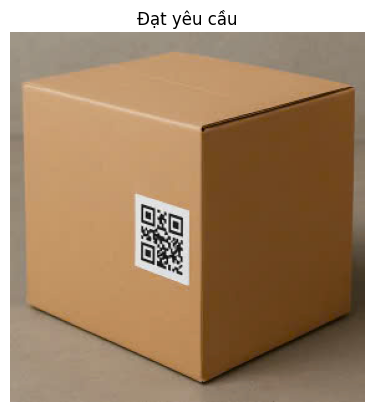

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model đã lưu
model = load_model('model_box.h5')

box_classes = ['dơ','không có mã code', 'móp', 'rách']
image_size = 128
threshold = 0.6  # Ngưỡng xác suất để đánh giá đạt hay không

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(image_path, image_size=128):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh: {image_path}")
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # shape: (1, 128, 128, 3)
    return img

# Đường dẫn ảnh muốn dự đoán
image_path = '/content/dat yeu cau.jpg'

# Tiền xử lý ảnh
img_input = preprocess_image(image_path, image_size)

# Dự đoán xác suất cho từng class
pred_prob = model.predict(img_input)[0]  # [0] để lấy mảng 1D

# Lấy class có xác suất cao nhất
predicted_class_idx = np.argmax(pred_prob)
confidence = pred_prob[predicted_class_idx]

# Kiểm tra đạt hay không dựa trên threshold
if confidence >= threshold:
    result = "Không đạt yêu cầu"
    predicted_label = box_classes[predicted_class_idx]
else:
    result = "Đạt yêu cầu"
    predicted_label = "Không phát hiện lỗi"

# In kết quả
print(f"Đánh giá tổng quát: {result}")
if result == "Không đạt yêu cầu":
    print(f"Dự đoán lỗi: {predicted_label} (Xác suất: {confidence:.4f})")

# Hiển thị ảnh kèm kết quả
img_display = cv2.imread(image_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
plt.imshow(img_display)
plt.axis('off')
plt.title(f"{result}" + (f" - {predicted_label} ({confidence:.2%})" if result=="Không đạt yêu cầu" else ""))
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Đánh giá tổng quát: Không đạt yêu cầu
Dự đoán lỗi: móp (Xác suất: 0.7560)


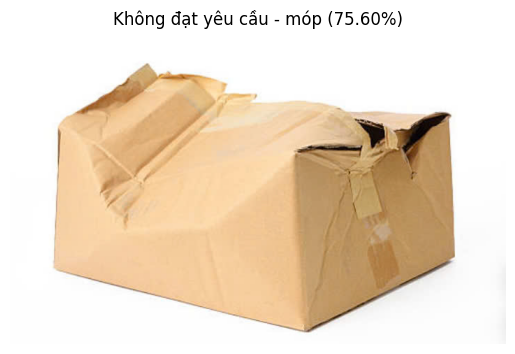

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model đã lưu
model = load_model('model_box.h5')

box_classes = ['dơ','không có mã code', 'móp', 'rách']
image_size = 128
threshold = 0.6  # Ngưỡng xác suất để đánh giá đạt hay không

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(image_path, image_size=128):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh: {image_path}")
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # shape: (1, 128, 128, 3)
    return img

# Đường dẫn ảnh muốn dự đoán
image_path = '/content/00f9ab84-f669-4045-9912-36b3a014a9a2.jfif'

# Tiền xử lý ảnh
img_input = preprocess_image(image_path, image_size)

# Dự đoán xác suất cho từng class
pred_prob = model.predict(img_input)[0]  # [0] để lấy mảng 1D

# Lấy class có xác suất cao nhất
predicted_class_idx = np.argmax(pred_prob)
confidence = pred_prob[predicted_class_idx]

# Kiểm tra đạt hay không dựa trên threshold
if confidence >= threshold:
    result = "Không đạt yêu cầu"
    predicted_label = box_classes[predicted_class_idx]
else:
    result = "Đạt yêu cầu"
    predicted_label = "Không phát hiện lỗi"

# In kết quả
print(f"Đánh giá tổng quát: {result}")
if result == "Không đạt yêu cầu":
    print(f"Dự đoán lỗi: {predicted_label} (Xác suất: {confidence:.4f})")

# Hiển thị ảnh kèm kết quả
img_display = cv2.imread(image_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
plt.imshow(img_display)
plt.axis('off')
plt.title(f"{result}" + (f" - {predicted_label} ({confidence:.2%})" if result=="Không đạt yêu cầu" else ""))
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Đánh giá tổng quát: Không đạt yêu cầu
Dự đoán lỗi: rách (Xác suất: 0.9098)


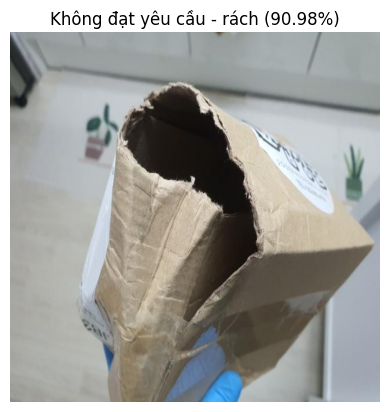

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model đã lưu
model = load_model('model_box.h5')

box_classes = ['dơ','không có mã code', 'móp', 'rách']
image_size = 128
threshold = 0.6  # Ngưỡng xác suất để đánh giá đạt hay không

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(image_path, image_size=128):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh: {image_path}")
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # shape: (1, 128, 128, 3)
    return img

# Đường dẫn ảnh muốn dự đoán
image_path = '/content/92eecde2293e34be90554986aa348fa4_jpeg_jpg.rf.a50ec3e40de8ab5b962fab6ef27ac660.jpg'

# Tiền xử lý ảnh
img_input = preprocess_image(image_path, image_size)

# Dự đoán xác suất cho từng class
pred_prob = model.predict(img_input)[0]  # [0] để lấy mảng 1D

# Lấy class có xác suất cao nhất
predicted_class_idx = np.argmax(pred_prob)
confidence = pred_prob[predicted_class_idx]

# Kiểm tra đạt hay không dựa trên threshold
if confidence >= threshold:
    result = "Không đạt yêu cầu"
    predicted_label = box_classes[predicted_class_idx]
else:
    result = "Đạt yêu cầu"
    predicted_label = "Không phát hiện lỗi"

# In kết quả
print(f"Đánh giá tổng quát: {result}")
if result == "Không đạt yêu cầu":
    print(f"Dự đoán lỗi: {predicted_label} (Xác suất: {confidence:.4f})")

# Hiển thị ảnh kèm kết quả
img_display = cv2.imread(image_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
plt.imshow(img_display)
plt.axis('off')
plt.title(f"{result}" + (f" - {predicted_label} ({confidence:.2%})" if result=="Không đạt yêu cầu" else ""))
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Đánh giá tổng quát: Không đạt yêu cầu
Dự đoán lỗi:  Không có mã code (Xác suất: 0.8844)


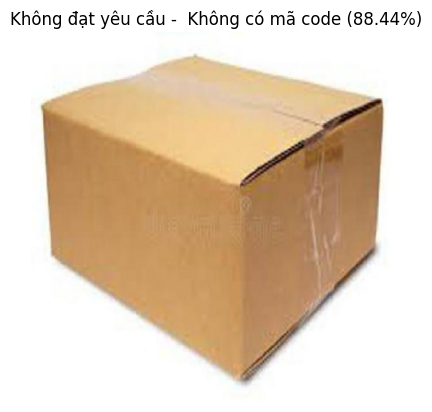

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model đã lưu
model = load_model('model_box.h5')

box_classes = ['dơ', 'Không có mã code', 'móp', 'rách']
image_size = 128
threshold = 0.6  # Ngưỡng xác suất để đánh giá đạt hay không

# Hàm tiền xử lý ảnh đầu vào
def preprocess_image(image_path, image_size=128):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh: {image_path}")
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # shape: (1, 128, 128, 3)
    return img

# Đường dẫn ảnh muốn dự đoán
image_path = '/content/413-jpg__jpg_jpg.rf.f494dff56814ca0f97a90c8889e56e50.jpg'

# Tiền xử lý ảnh
img_input = preprocess_image(image_path, image_size)

# Dự đoán xác suất cho từng class
pred_prob = model.predict(img_input)[0]  # [0] để lấy mảng 1D

# Lấy class có xác suất cao nhất
predicted_class_idx = np.argmax(pred_prob)
confidence = pred_prob[predicted_class_idx]

# Kiểm tra đạt hay không dựa trên threshold
if confidence >= threshold:
    result = "Không đạt yêu cầu"
    predicted_label = box_classes[predicted_class_idx]
else:
    result = "Đạt yêu cầu"
    predicted_label = "Không phát hiện lỗi"

# In kết quả
print(f"Đánh giá tổng quát: {result}")
if result == "Không đạt yêu cầu":
    print(f"Dự đoán lỗi: {predicted_label} (Xác suất: {confidence:.4f})")

# Hiển thị ảnh kèm kết quả
img_display = cv2.imread(image_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
plt.imshow(img_display)
plt.axis('off')
plt.title(f"{result}" + (f" - {predicted_label} ({confidence:.2%})" if result=="Không đạt yêu cầu" else ""))
plt.show()
